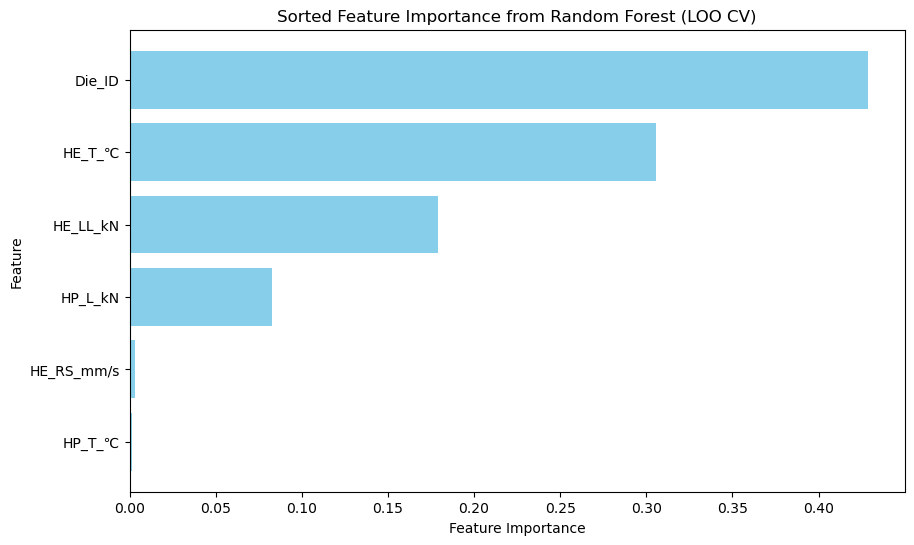

RMSE of RF predictions: 26.53 kJ/m^3
RMSE of RF predictions: 26.53 kJ/m^3
RMSE of RF predictions: 26.53 kJ/m^3
RMSE of RF predictions: 26.53 kJ/m^3
RMSE of RF predictions: 26.53 kJ/m^3
RMSE of RF predictions: 26.53 kJ/m^3
RMSE of RF predictions: 26.53 kJ/m^3


c:\opt\envs\tensorflow\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut
from scipy.stats import norm
from itertools import product
import memory_profiler
from memory_profiler import profile

# Load the initial 18 samples
# Define the directory structure
base_dir = 'D:\Computations\HotRollProcess'
file_name = 'magnetic_database.xlsx'

# Construct the full file path
file_path = os.path.join(base_dir, file_name)

# Read the Excel file using Pandas
data = pd.read_excel(file_path, header=[0, 1])

# Combine multi-level headers into single-level headers
data.columns = ['_'.join(col).strip() for col in data.columns.values]

# Rename the columns
new_column_names = {
    'Date_#': 'Date',
    'ID_#': 'ID',
    'Position_#': 'Position',
    '(BH)max_kJ/m^3_kJ/m^3': '(BH)max_kJ/m^3',
    '(BH)max_MGOe_MGOe': '(BH)max_MGOe',
    'm0Hc_T_T': 'μ0Hc_T',
    'm0Br_T_T': 'μ0Br_T',
    'Sq._%_%': 'Sq._%',
    'HP_T_℃_℃': 'HP_T_℃',
    'HP_L_kN_kN': 'HP_L_kN',
    'HE_T_℃_℃': 'HE_T_℃',
    'HE_RS_mm/s_mm/s': 'HE_RS_mm/s',
    'HE_LL_kN': 'HE_LL_kN',
    'Die_ID_#': 'Die_ID'
}

data.rename(columns=new_column_names, inplace=True)

# Extract features and target
X = data[['HP_T_℃', 'HP_L_kN', 'HE_T_℃', 'HE_RS_mm/s', 'HE_LL_kN', 'Die_ID']].values.astype('float32')
y = data['(BH)max_kJ/m^3'].values.astype('float32')


# Define tunable process parameters
param_space = {
    'HPT_°C': np.arange(500, 801, 25),
    'HPL_kN': np.arange(50, 701, 10),
    'HET_°C': np.arange(750, 901, 25),
    'HERS_mm/s': np.arange(0.1, 10.1, 0.1),
    'HELL_kN': np.arange(10, 101, 10),
    'DieID': np.arange(0, 11, 1)
}

# Function to perform Leave-One-Out cross-validation and get feature importances
def calculate_feature_importances(X, y):
    loo = LeaveOneOut()
    feature_importances = np.zeros((len(X), len(X[0])))

    for i, (train_index, test_index) in enumerate(loo.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)

        feature_importances[i] = rf.feature_importances_

    mean_feature_importances = feature_importances.mean(axis=0)
    return mean_feature_importances

mean_feature_importances = calculate_feature_importances(X, y)
feature_names = ['HP_T_℃', 'HP_L_kN', 'HE_T_℃', 'HE_RS_mm/s', 'HE_LL_kN', 'Die_ID']

# Sort feature importances and feature names together
sorted_indices = np.argsort(mean_feature_importances) #[::-1]  # Sort in ascending order
sorted_feature_importances = mean_feature_importances[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Plot the sorted feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_feature_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Sorted Feature Importance from Random Forest (LOO CV)')
plt.show()

# Function to train RF regressors and perform leave-one-out cross-validation
def train_rf_and_cross_val(X, y, ensemble_size):
    loo = LeaveOneOut()
    rf_models = []
    rf_predictions = []
    observed_values = []

    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)
        rf_models.append(rf)

        y_pred = rf.predict(X_test)
        rf_predictions.append(y_pred[0])
        observed_values.append(y_test[0])

    rmse = np.sqrt(mean_squared_error(observed_values, rf_predictions))
    print(f"RMSE of RF predictions: {rmse:.2f} kJ/m^3")

    return rf_models

# Train 3 ensembles of 18 RF regressors each
num_ensembles = 3
ensemble_size = 18
ensemble_rf_models = []

for _ in range(num_ensembles):
    ensemble_rf_models.append(train_rf_and_cross_val(X, y, ensemble_size))


# Train 3 ensembles of 18 RF regressors each
num_ensembles = 3
ensemble_size = 18
ensemble_rf_models = []

for _ in range(num_ensembles):
    ensemble_rf_models.append(train_rf_and_cross_val(X, y, ensemble_size))

# Example of accessing a specific RF regressor from the first ensemble
# First ensemble, first RF regressor
rf_model_0_0 = ensemble_rf_models[0][0][0]

# Function to initialize GP regressor with random samples evaluated through RF
def initialize_gp_with_rf_samples(X, rf_models):
    n_random_samples = 100
    random_indices = np.random.choice(len(X), n_random_samples, replace=False)
    X_random = X[random_indices]
    y_random = []

    for i in random_indices:
        y_random.append(rf_models[i % len(rf_models)].predict(X[i].reshape(1, -1))[0])

    X_random = np.array([X[i] for i in random_indices])
    y_random = np.array(y_random)

    return X_random, y_random

# Add @profile decorator to the Bayesian function for memory check
#@profile
# Bayesian Optimization to find the next set of parameters
def bayesian_optimization(gp, param_space, X_random, y_random):
    def expected_improvement(X, model, y_max):
        mu, sigma = model.predict(X, return_std=True)
        with np.errstate(divide='warn'):
            imp = mu - y_max - 0.01
            Z = imp / sigma
            ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
            ei[sigma == 0.0] = 0.0
        return ei

    param_combinations = np.array(list(product(*[param_space[param] for param in param_space.keys()])))
    chunk_size = 1000  # Define chunk size
    n_chunks = len(param_combinations) // chunk_size + (len(param_combinations) % chunk_size > 0)  # Calculate number of chunks

    top_samples = np.empty((0, len(param_space.keys())))  # Initialize empty array to store top samples

    # Define a generator function to yield batches of parameter combinations
    def parameter_batches():
        for i in range(n_chunks):
            start_idx = i * chunk_size
            end_idx = min((i + 1) * chunk_size, len(param_combinations))
            yield param_combinations[start_idx:end_idx]

    for batch in parameter_batches():
        ei = expected_improvement(batch, gp, max(y_random))
        top_indices = np.argsort(ei)[-10:]
        top_samples = np.vstack((top_samples, batch[top_indices]))

    return top_samples


# Function to experimentally evaluate the top samples and update the dataset
def evaluate_top_samples(top_samples):
    global data, X, y  # Declare data, X, and y as global variables
    # Here, we simulate experimental evaluation by generating random values
    to_concat = []
    for sample in top_samples:
        new_BH_max = np.random.uniform(180, 210)  # Placeholder for actual experimental result
        new_row = {
            'HP_T_℃': sample[0], 'HP_L_kN': sample[1], 'HE_T_℃': sample[2],
            'HE_RS_mm/s': sample[3], 'HE_LL_kN': sample[4], 'Die_ID': sample[5],
            '(BH)max_kJ/m^3': new_BH_max
        }
        to_concat.append(pd.Series(new_row))

        # Update X and y with new data
        X = np.vstack((X, sample))
        y = np.append(y, new_BH_max)

    new_data = pd.DataFrame(to_concat)
    data = pd.concat([data, new_data], ignore_index=True)
    return X, y

# Initialize RF models and train
rf_models = train_rf_and_cross_val(X, y,ensemble_size)

# Initialize GP with RF samples
X_random, y_random = initialize_gp_with_rf_samples(X, rf_models)

# Define GP kernel
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0)

# Initialize and fit Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, n_restarts_optimizer=2)
gp.fit(X_random, y_random)

# Perform Bayesian Optimization for 5 cycles
num_cycles = 5

for _ in range(num_cycles):
    # Perform Bayesian Optimization for each cycle
    top_samples = bayesian_optimization(gp, param_space, X_random, y_random)
    
    # Evaluate top samples and update the dataset
    X, y = evaluate_top_samples(top_samples)

# Evaluate top samples and update the dataset
X, y = evaluate_top_samples(top_samples)

# Save the updated dataset
data.to_csv('updated_magnet_data.csv', index=False)

# For each sample, calculate the (BH)max for each series of measurements
data['(BH)max_kJ/m^3'] = data.apply(lambda row: row['μ0Hc_T'] * row['μ0Br_T'] * row['Sq_%'], axis=1)

# Group by sample ID and calculate the mean (BH)max for each sample
sample_means = data.groupby('ID')['(BH)max_kJ/m^3'].mean()

# Plot the evolution of (BH)max as a function of the sample number
plt.figure(figsize=(10, 6))
plt.plot(sample_means.index, sample_means.values, marker='o', linestyle='-')
plt.xlabel('Sample Number')
plt.ylabel('(BH)max (kJ/m^3)')
plt.title('Evolution of (BH)max as a Function of Sample Number')
plt.grid(True)
plt.show()

# Call your function
#if __name__ == "__main__":
 #   my_function()

In [22]:
data.head(10)

,Date_Unnamed: 0_level_1,ID,Position,(BH)max_kJ/m^3,(BH)max_MGOe,m0Hc_T,m0Br_T,Sq._%,HP_T_℃,HP_L_kN,HE_T_℃,HE_RS_mm/s,HE_LL_kN,Die_ID
0,2019-06-04,28,1,198.870420,24.990,1.246,1.084,0.921700,600,700,850,1.0,20,2
1,2019-06-05,29,1,193.538560,24.320,1.416,1.065,0.919600,600,700,850,1.0,20,3
2,NaT,29,2,199.984540,25.130,1.396,1.082,0.923900,600,700,850,1.0,20,3
3,2019-06-12,30,1,185.898880,23.360,1.354,1.045,0.920700,600,700,850,1.0,20,1
4,NaT,30,2,202.690260,25.470,1.398,1.059,0.902800,600,700,850,1.0,20,1
5,2019-06-14,32,1,249.722040,31.380,1.213,1.181,0.949300,600,700,800,1.0,35,0
6,NaT,32,4,275.267220,34.590,1.207,1.219,0.968228,600,700,800,1.0,35,0
7,NaT,32,5,257.194602,32.319,1.227,1.181,0.961720,600,700,800,1.0,35,0
8,NaT,32,6,263.895238,33.161,1.258,1.199,0.960730,600,700,800,1.0,35,0
9,NaT,32,9,243.498884,30.598,1.260,1.158,0.957810,600,700,800,1.0,35,0
